In [2]:
%matplotlib notebook
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from schlichtanders.mymatplotlib import Centre
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
import pandas as pd
import numpy as np
import theano
import theano.tensor as T
import theano_models as tm
import theano_models.deterministic_models as dm
import theano_models.probabilistic_models as pm

In [4]:
from experiment_toy_models import toy_likelihood

gnumpy: failed to import cudamat. Using npmat instead. No GPU will be used.


In [5]:
from schlichtanders.myfunctools import meanexp

In [6]:
toy1d = toy_likelihood(1)
toy2d = toy_likelihood(2)

toy1d_sampler = theano.function([], toy1d['outputs'])
toy2d_sampler = theano.function([], toy2d['outputs'])

toy1d_lik = theano.function(toy1d.logP['inputs'] + toy1d['inputs'], toy1d.logP['outputs'])
toy2d_lik = theano.function(toy2d.logP['inputs'] + toy2d['inputs'], toy2d.logP['outputs'])

In [7]:
toy1d

Merge2 { 'inputs': [TensorConstant{(1,) of 0.0}], 'outputs': GaussianNoise.outputs}

In [8]:
def make_prior(targets):
    total_size = tm.total_size(targets['inputs'])
    return tm.fix_params(pm.DiagGauss(output_size=total_size))
prior1 = make_prior(toy1d)
prior2 = make_prior(toy2d)

prior1_sampler = prior1.function()
prior2_sampler = prior2.function()

prior1_logP = prior1.logP.function()
prior2_logP = prior2.logP.function()

Samples

In [9]:
# n_samples = 1000
n_samples = 800  # 80% training data, however we need to average this over multiple trials
toy1d_samples = [toy1d_sampler() for _ in xrange(n_samples)]
toy2d_samples = [toy2d_sampler() for _ in xrange(n_samples)]

overall log likelihood of sample is simple sum

In [10]:
def sample_lik1(w):
    return sum(toy1d_lik(s, w) for s in toy1d_samples)

def sample_lik2(w):
    return sum(toy2d_lik(s, w) for s in toy2d_samples)

In [11]:
normalizing_samples = 10000

normalizing_constant1 = meanexp([sample_lik1(prior1_sampler()) for _ in xrange(normalizing_samples)])
normalizing_constant2 = meanexp([sample_lik2(prior2_sampler()) for _ in xrange(normalizing_samples)])

In [11]:
@np.vectorize
def posterior1(w):
    return sample_lik1([w]) + prior1_logP([w]) - normalizing_constant1
    
@np.vectorize
def posterior2(w1, w2):
    return sample_lik2([w1, w2]) + prior2_logP([w1, w2]) - normalizing_constant2

In [12]:
ws = np.linspace(-1.5, 1.5, 100)
num_posterior1 = posterior1(ws)

In [13]:
_ws = np.linspace(-1.5, 1.5, 50)
W1, W2 = np.meshgrid(_ws, _ws)
num_posterior2 = posterior2(W1, W2)

In [14]:
num_posterior2

array([[ -6.42868416e+04,  -5.70536283e+04,  -5.08774263e+04, ...,
         -7.82310486e+02,  -2.14747900e+02,   1.06057497e+00],
       [ -6.16895748e+04,  -5.46083772e+04,  -4.85697983e+04, ...,
         -5.19311588e+02,  -8.93721685e+01,  -2.55793709e+01],
       [ -5.91458609e+04,  -5.22166790e+04,  -4.63157233e+04, ...,
         -3.09865555e+02,  -1.75493018e+01,  -1.05772182e+02],
       ..., 
       [ -1.05950781e+02,  -1.74743965e+01,  -3.09561146e+02, ...,
         -4.63120092e+04,  -5.22127354e+04,  -5.91416638e+04],
       [ -2.56686706e+01,  -8.92079635e+01,  -5.18917879e+02, ...,
         -4.85659950e+04,  -5.46043444e+04,  -6.16852884e+04],
       [  1.06057497e+00,  -2.14494395e+02,  -7.81827478e+02, ...,
         -5.08735336e+04,  -5.70495061e+04,  -6.42824659e+04]])

<IPython.core.display.Javascript object>


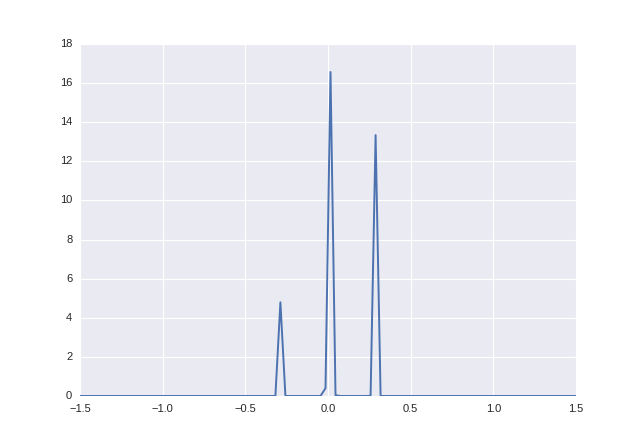

In [15]:
plt.figure()
plt.plot(ws, np.exp(num_posterior1))

<IPython.core.display.Javascript object>


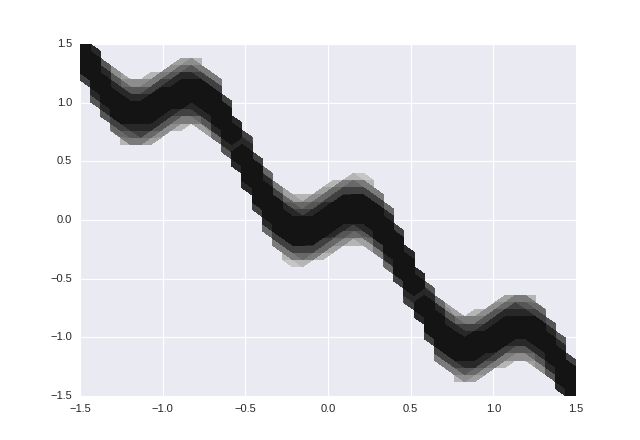

/usr/local/lib/python2.7/dist-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


In [16]:
plt.figure()
plt.contourf(W1, W2, np.exp(num_posterior2), norm=LogNorm())
# plt.colorbar()

<IPython.core.display.Javascript object>


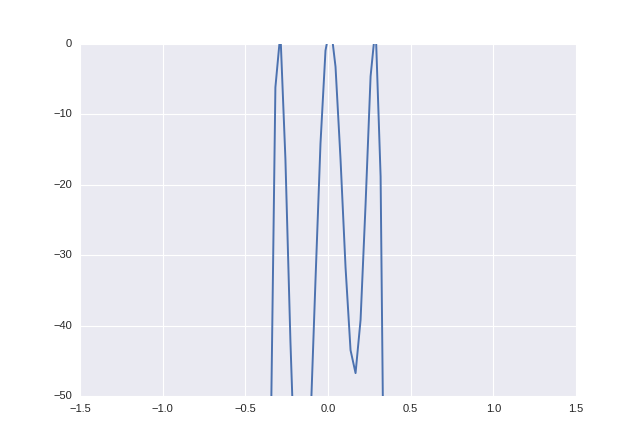

(-50, 0)

In [17]:
plt.figure()
plt.plot(ws, num_posterior1)
plt.ylim([-50, 0])

In [20]:
10**3

1000

<IPython.core.display.Javascript object>


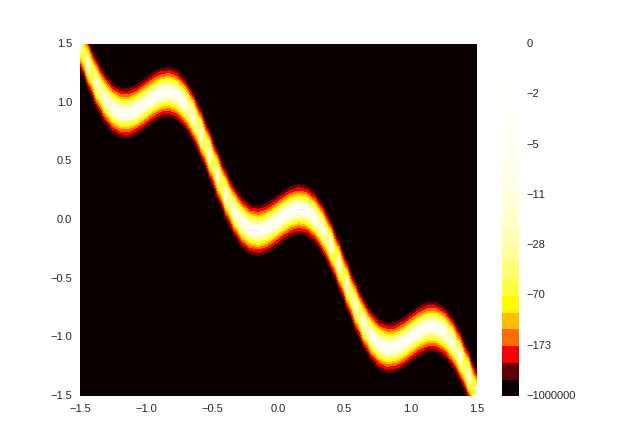

In [22]:
plt.figure()
levels = - np.r_[0, np.logspace(0, 2.5, 20)][::-1]
vmin=levels.min()
vmax=levels.max()
levels = np.r_[-10**6, levels]
plt.contourf(W1, W2, num_posterior2, levels, vmin=vmin, vmax=vmax, cmap=plt.cm.hot)
plt.colorbar()